### Daytum +2 Course: Data Analytics, Geostatistics and Machine Learning Deep Dive

### Advanced Clustering Demonstration and Exercise

#### Goal 

Gain experience with advanced clustering methods, beyond k-means clustering for more challenging data.

* **k-Means clustering** as a centroid-based clustering method with predetermined number of clusters

* **DBSCAN**, density-based spatial clustering of applications with noise, as a density-based clustering method without predetermined number of clusters

* **Spectral clustering** as a hierarchical connectivity-based clustering method with predetermined number of clusters

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import copy                               # for deep copies
from sklearn.neighbors import NearestNeighbors # nearest neighbours function to calculate eps hyperparameter
from sklearn.preprocessing import MinMaxScaler # min/max normalization
from sklearn.cluster import KMeans        # k-means clustering
from sklearn.cluster import DBSCAN        # DBSCAN clustering
from sklearn.cluster import SpectralClustering # spectral clustering
from intake import cat

/opt/tljh/user/lib/python3.7/site-packages/intake/source/discovery.py:137: FutureWarning: The drivers ['sql_cat', 'sql', 'sql_auto', 'sql_manual'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


#### Loading Data

Let's load the provided multivariate, spatial dataset 'nonlinear_facies_v1'.  It is a file with: 

* X and Y coordinates ($m$)
* facies 0 and 1 
* porosity (fraction)
* permeability ($mD$)
* acoustic impedance ($\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$). 
``

Let's load the data and then this command to extract a random subset of the data.

```python
df = df.sample(frac=.30, random_state = 73073); 
df = df.reset_index()
```

We do this to reduce the number of data for ease of visualization (hard to see if too many points on our plots).

After the walk through, we will switch to experiential and you will load a new dataset and build your own clusters!

```python
experiential = True
```

In [3]:
experiential = False

if experiential == False:
    col = ['Por','Perm','Facies']
    xlim = [0,25]; ylim = [0,1200]; xlabel = 'Porosity (%)'; ylabel = 'Permeability (mD)'
    units = ['%','mD']
    df = cat.nonlinear_facies_v1.read()    # load our data table
    
else:
    col = ['AI','Por','Facies']
    units = ['kg/m2*10^3','%']
    xlim = [0,1200]; ylim = [0,30]; xlabel = 'Acoustic Impedance (kg/m^2s*10^3)'; ylabel = 'Porosity (%)'
    df = cat.nonlinear_facies_v2.read()    # load our data table

df = df[[col[0],col[1],col[2]]]
df.head()

#df = df.sample(frac=1.0, random_state = 73073); df = df.reset_index() # extract 30% random to reduce the number of data

,Por,Perm,Facies
0,5.884729,777.927713,3
1,5.579639,741.831286,3
2,3.732165,720.502871,3
3,3.081551,545.878794,3
4,9.079613,888.300959,3


#### Summary Statistics for Tabular Data

The table includes porosity (fraction) and acoustic impedance ($\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$) that we will work with in the demonstration below.

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Por,1700.0,15.900026,7.241663,0.0,10.000000,18.343307,21.753840,30.0
Perm,1700.0,982.424677,220.903674,10.0,847.051401,1065.011848,1154.053445,1200.0
Facies,1700.0,1.647059,0.836285,1.0,1.000000,1.000000,2.000000,3.0


Let's also check the proportion of facies.

* we will not use these, but they indicate the proportion of samples in each cluster

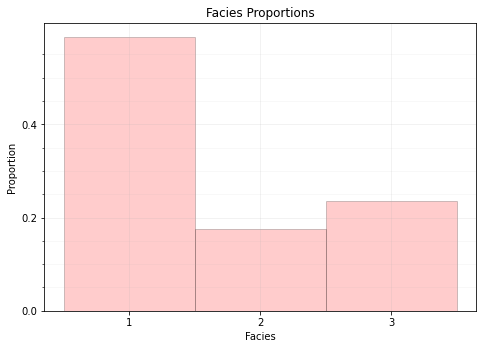

In [5]:
plt.hist(df['Facies'],alpha=0.2,color="red",edgecolor="black",bins=[0.5,1.5,2.5,3.5],label = ['Shale','SandShale','Sand'],range=[0.5,2.5],density = True)
plt.title('Facies Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(1.0, 3.1, 1))
ax.set_yticks(np.arange(0, 0.6, 0.2))
ax.set_yticks(np.arange(0, 0.6, 0.05), minor=True)

#plt.grid(which = 'both',color = 'black',alpha = 0.01)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

The two features are quite incompatible.  They have dramatically different:

* magnitudes / averages

* variances / ranges

We should make a normalized version of each.  We will scale the variables to range from 0 to 1.  

* There is no distribution shape change.

We will use these normalized values for calculating distance in our workflow:

* to remove the influence of magnitude and range on our similarity calculation

In [6]:
transform = MinMaxScaler(); 
features = [col[0],col[1]]

df['n' + col[0]] = transform.fit_transform(df.loc[:,features].values)[:,0] # standardize the data features to mean = 0, var = 1.0
df['n' + col[1]] = transform.fit_transform(df.loc[:,features].values)[:,1] # standardize the data features to mean = 0, var = 1.0
df.head()

,Por,Perm,Facies,nPor,nPerm
0,5.884729,777.927713,3,0.196158,0.645317
1,5.579639,741.831286,3,0.185988,0.614984
2,3.732165,720.502871,3,0.124405,0.597061
3,3.081551,545.878794,3,0.102718,0.450318
4,9.079613,888.300959,3,0.302654,0.738068


Let's confirm that our normalized porosity and acoustic impedance now range between 0 and 1.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Por,1700.0,15.900026,7.241663,0.0,10.000000,18.343307,21.753840,30.0
Perm,1700.0,982.424677,220.903674,10.0,847.051401,1065.011848,1154.053445,1200.0
Facies,1700.0,1.647059,0.836285,1.0,1.000000,1.000000,2.000000,3.0
nPor,1700.0,0.530001,0.241389,0.0,0.333333,0.611444,0.725128,1.0
nPerm,1700.0,0.817164,0.185633,0.0,0.703405,0.886565,0.961389,1.0


Here's the actual facies categories. 

* for this workflow this is our inaccessible truth model

* we will leave these categories out and attempt to automate their assignment with a variety of clustering

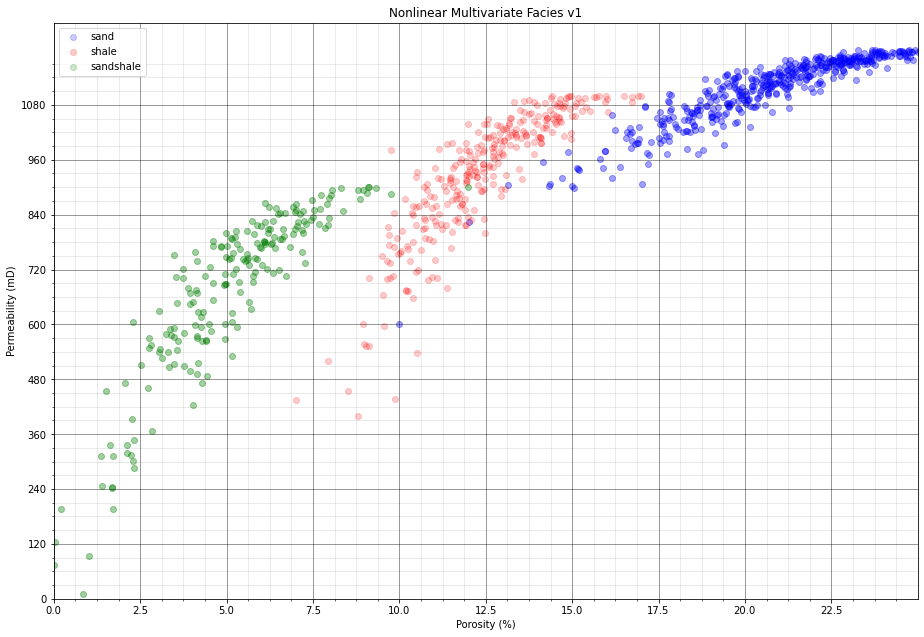

In [8]:
df1 = df[df['Facies'] == 1]; df2 = df[df['Facies'] == 2]; df3 = df[df['Facies'] == 3]
cmap = {1: 'r', 2: 'g', 3: 'b', 4: 'm', 5: 'c', 6: 'k', 7: 'w'}

# plot the result
plt.subplot(111)
plt.scatter(df1[col[0]],df1[col[1]],color = 'blue',alpha = 0.2,cmap = cmap,vmin = 1, vmax = 4,label = 'sand')
plt.scatter(df2[col[0]],df2[col[1]],color = 'red',alpha = 0.2,cmap = cmap,vmin = 1, vmax = 4,label = 'shale')
plt.scatter(df3[col[0]],df3[col[1]],color = 'green',alpha = 0.2,cmap = cmap,vmin = 1, vmax = 4,label = 'sandshale')
plt.xlim(0,25)
plt.ylim(0.1200)

ax = plt.gca()
ax.set_xticks(np.arange(xlim[0], xlim[1], (xlim[1]-xlim[0])/10))
ax.set_xticks(np.arange(xlim[0], xlim[1], (xlim[1]-xlim[0])/40), minor=True)
ax.set_yticks(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/10))
ax.set_yticks(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/40), minor=True)


plt.grid(which = 'both',color = 'black',alpha = 0.2)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.5)
plt.xlabel(xlabel); 
plt.ylabel(ylabel); plt.title('Nonlinear Multivariate Facies v1')
plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.2, hspace=0.2)


Ok, let's ignore the truth facies cateogrical assignments and move forward.

#### Some Parameters

From the summary statistics we can assign a reasonable minimum and maximum for each feature.  

* We will use this for plotting.

We will also set the random number seed to ensure that the program does the same thing everytime it is run.

* Change the seed number for a different result

We will set the number of prototypes / clusters, *K*

We define a dictionary with the color code for each cluster, $k = 1,\ldots,K$.  Given 7 codes currently, there will be an error if $K$ is set larger than 7.  Add more color codes to the dictionary to allow for mor categories.

In [9]:
np.random.seed(210)
K = 3                                     # number of prototypes
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'm', 5: 'c', 6: 'k', 7: 'w'}

#### Visualization of Training Data

In this exercise, we want to use K-means clustering provide facies based on acoustic impedance and porosity predictor features. 

* This allows use to group rock with similar petrophysical and geophysical properties.

Let's start by looking at the scatterplot of our training data features, porosity and acoustic impedance.  

* We will look at the data in original units and normalized units through this entire exercise.

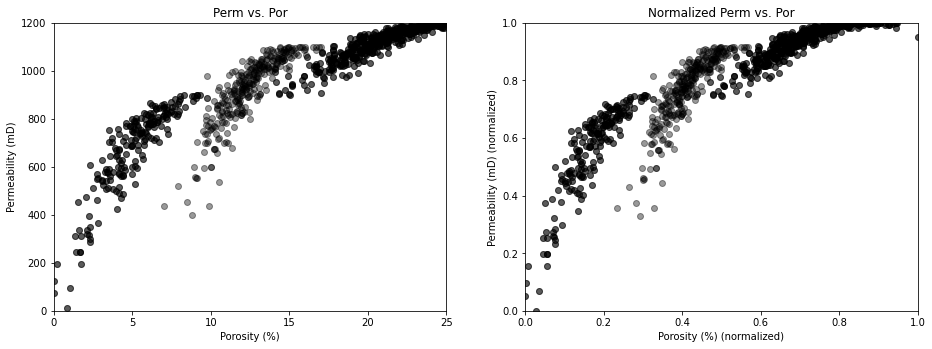

In [10]:
# scatter plot our training data  
plt.subplot(121)
plt.scatter(df[col[0]], df[col[1]], c="black", alpha = 0.4, linewidths=1.0, edgecolors="black")
plt.title(col[1] + ' vs. ' + col[0]); plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(122)
plt.scatter(df['n' + col[0]], df['n' + col[1]], c="black", alpha = 0.4, linewidths=1.0, edgecolors="black")
plt.title('Normalized ' + col[1] + ' vs. ' + col[0]); plt.xlabel(xlabel + ' (normalized)'); plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

#### k-Means Clustering

First we start with k-means clustering. 

* I have an entire demonstration dedicated to [k-means cluster](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Clustering.ipynb).

* We use k-means to baseline the subsequent approaches that we will attempt.

Let's be mindful of the assumptions of k-means clustering:

* spherical variability over the features

* same variability over each feature (after our min/max normalization)

* prior probability of membership in all clusters, equal number of samples in each

This dataset violates these assumptions with non spherical shapes, inequal proportions of samples in each cluster (we know this because we have the truth facies and we can peak, or by ocular inspection).

* Given the nonconvexity of the sample data in feature space this should not work well.

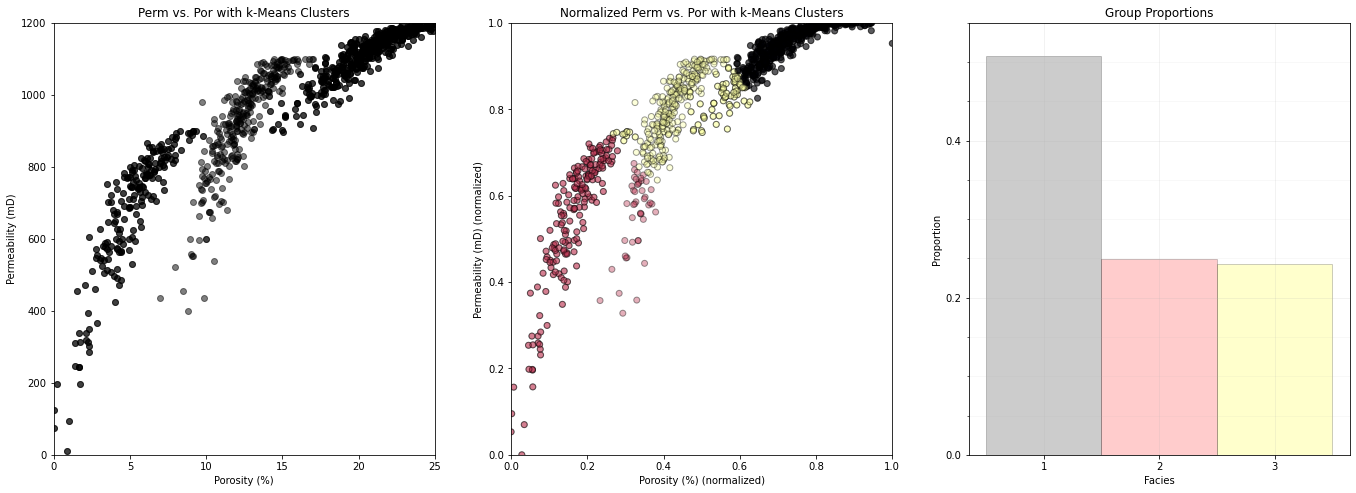

In [11]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df[['n'+col[0],'n'+col[1]]].values)
df['kMeans'] = kmeans.labels_ + 1

cmap = plt.cm.inferno

plt.subplot(131)                          # plot the assigned training data and K prototypes
plt.scatter(df[col[0]], df[col[1]], c='black',alpha=0.5, edgecolor='k', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with k-Means Clusters'); plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(132)                          # plot the training data and K prototypes
plt.scatter(df['n' + col[0]], df['n' + col[1]], c=df['kMeans'], alpha = 0.4, linewidths=1.0, edgecolors="black", cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with k-Means Clusters'); plt.xlabel(xlabel + ' (normalized)'); plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df['kMeans'],alpha=0.2,edgecolor="black",bins=[0.5,1.5,2.5,3.5],range=[0.5,2.5],density = True)
patches[0].set_facecolor('black'); patches[1].set_facecolor('red'); patches[2].set_facecolor('yellow');
plt.title('Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(1.0, 3.1, 1))
ax.set_yticks(np.arange(0, 0.6, 0.2))
ax.set_yticks(np.arange(0, 0.6, 0.05), minor=True)

#plt.grid(which = 'both',color = 'black',alpha = 0.01)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)


As expected there are issues:

* the non-convex, nonlinear shapes, and low-density representation of edges of clusters are not captured well

As a results obvious connected geometries are broken up.

##### Clustering without Normalization / Standardization

One of the critical assumptions of clustering is that the variability is the same over each feature.

* an exception would be if the features have the same units and the variability differences are meaningful 

Let's take this dataset and draw it to scale (to show what a distance metric would see in original units.

* we rotate the plot and provide an approximate visualization with porosity 1 unit equal to permeability 1 unit on the plot

* effectively the dataset looks 1D to the clustering algorithm, difference in porosity becomes meaningless

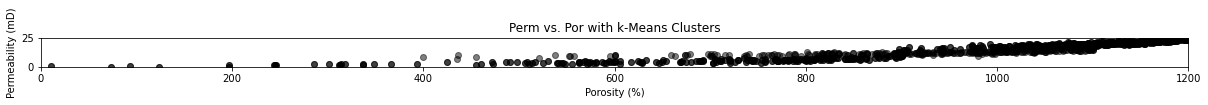

In [12]:
plt.subplot(131)                          # plot the assigned training data and K prototypes
plt.scatter(df[col[1]],df[col[0]], c='black',alpha=0.5, edgecolor='k', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with k-Means Clusters'); plt.ylabel(ylabel); plt.xlabel(xlabel)
plt.ylim(xlim)
plt.xlim(ylim)

plt.subplots_adjust(left=0.0, bottom=0.0, right=8.5, top=0.10, wspace=0.1, hspace=0.2)

To further motivate the use of normalization/standardization, let's apply k-means clusters on the original data (without transformation).

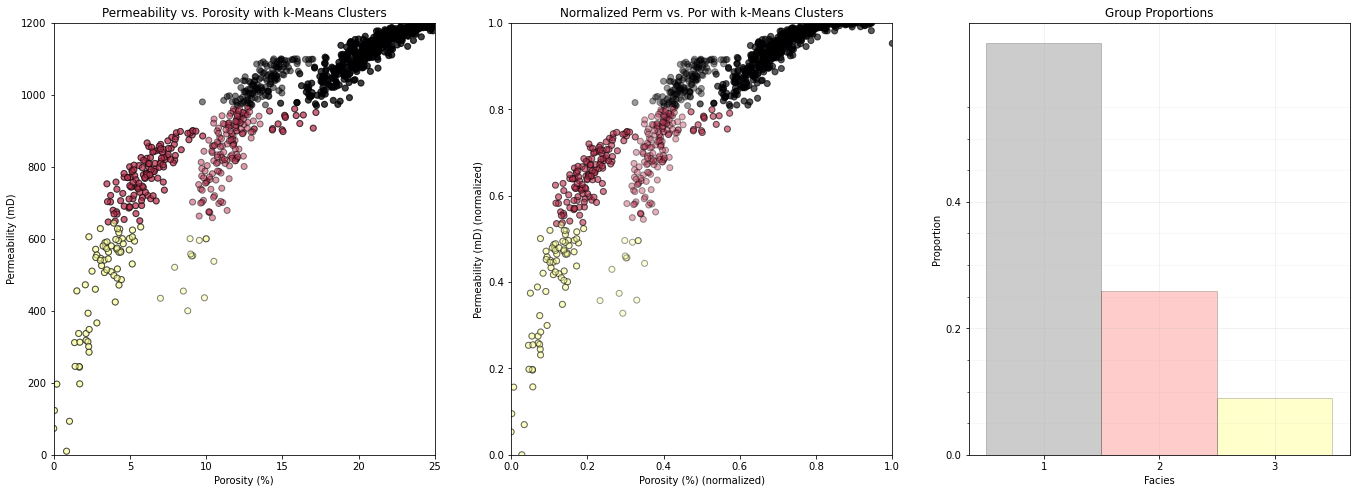

In [13]:
kmeans_orig = KMeans(n_clusters=3, random_state=0).fit(df[[col[0],col[1]]].values)
df['kMeans_orig'] = kmeans_orig.labels_ + 1

plt.subplot(131)                          # plot the assigned training data and K prototypes
plt.scatter(df[col[0]], df[col[1]], c=df['kMeans_orig'],alpha=0.5, edgecolor='k', cmap = cmap)
plt.title('Permeability vs. Porosity with k-Means Clusters'); plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(132)                          # plot the training data and K prototypes
plt.scatter(df['n'+col[0]], df['n'+col[1]], c=df['kMeans_orig'], alpha = 0.4, linewidths=1.0, edgecolors="black", cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with k-Means Clusters'); plt.xlabel(xlabel + ' (normalized)'); plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df['kMeans_orig'],alpha=0.2,edgecolor="black",bins=[0.5,1.5,2.5,3.5],range=[0.5,2.5],density = True)
patches[0].set_facecolor('black'); patches[1].set_facecolor('red'); patches[2].set_facecolor('yellow');
plt.title('Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(1.0, 3.1, 1))
ax.set_yticks(np.arange(0, 0.6, 0.2))
ax.set_yticks(np.arange(0, 0.6, 0.05), minor=True)

#plt.grid(which = 'both',color = 'black',alpha = 0.01)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)

Note the clustering was conducted over permeability and the porosity differences had no impact due to the difference in variance of permeability and porosity.

#### DBSCAN Clustering

The DBSCAN approach randomly finds clusters of samples (high density) is well suited to working with data with an arbitrary (even non-convex) shape and with noise.

The two parameters include:

* **eps** - maximum distance between to samples in features space for a sample to be included in the neighbourhood of the other sample. Too small a value will result in many clusters and outliers, and too large a value will result in one cluster with all the data together.

* **min_samples** - minimum number of samples in a neighbourhood to spawn a new cluster. Use a larger value for noisy data to prevent identifying clusters due to a few outliers.

The method proceeds through the dataset and assigns the samples as:

* **core** point if there are $\ge$ **min_samples** within **eps** distance from the sample

* **border** point if there are $lt$ **min_samples** within **eps** distance from the sample, but the sample is within **eps** distance of a core point.

* **outlier** point if there are $lt$ **min_samples** within **eps** distance from the sample and the sample is not within **eps** distance of a core point

Once the points are assigned these labels, all connected core points and their associate border points are assigned to an unique cluster.  Outlier points are left as outliers without an assigned cluster.  To understand the cluster assigments we should explain the following forms of connection.

**directly density reachable** - point X is directly density reachable from A, if A is a core point and X belongs to the neighborhood (distance $le$ eps) from A.

**density-reachable** - point Y is density reachable from A if Y belongs to a neighborhood of a core point that can reached from A. This would require a chain of core points each belonging the previous core points and the last core point including point Y.

**density-connected** - points A and B are density-connected if there is a point Z that is density-reachable from both points A and B.

**density-based cluster** - a nonempty set where all points are density-connected to eachother. 

The approach iterates as follows:

1. all points are labled as unvisited

2. randomly visit an unvisited sample

3. check if a core point ($ge$ min_sample within eps distance), if so label as core otherwise label as outlier

4. now visit all points within eps distance of the core point, determine if core, otherwise label as border point

5. recusive operation where all points within eps distance of new core points are checked

6. once this is exhausted then randomly visit an unvisited point

This apporach may be thought of as identify and grow/merge clusters guided by local point density.


After some careful interations of these parameters we get the following result.

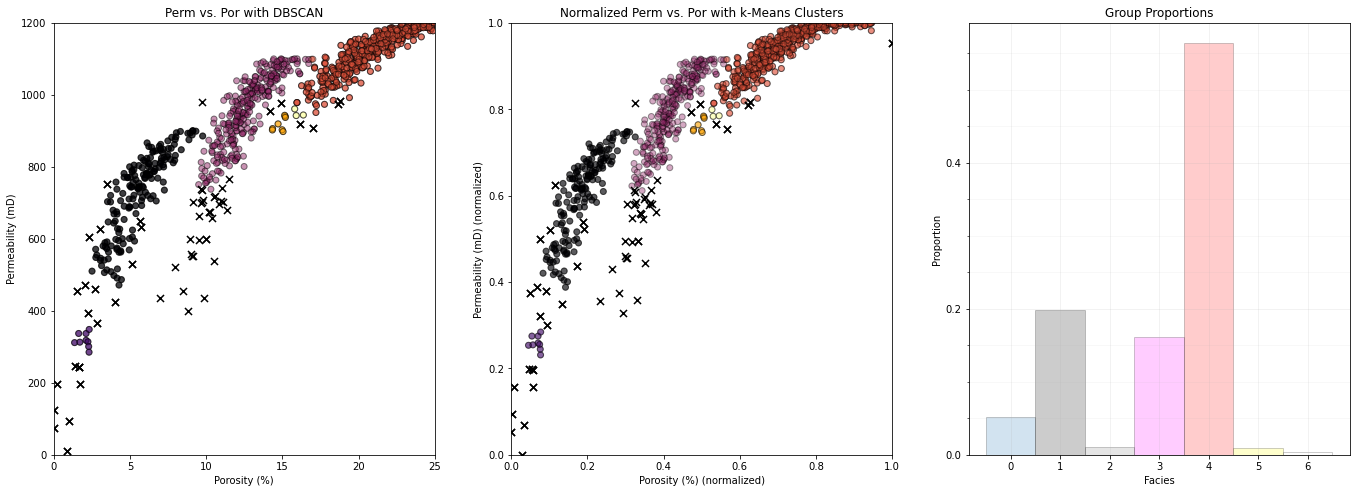

In [14]:
dbscan = DBSCAN(eps=0.029, min_samples=15).fit(df[['n'+col[0],'n'+col[1]]].values)
df['DBSCAN'] = dbscan.labels_ + 1

cmap = plt.cm.inferno

plt.subplot(131)                          # plot the assigned training data and K prototypes
df_in = df.loc[(df['DBSCAN'] != 0)]
plt.scatter(df_in[col[0]], df_in[col[1]], c=df_in['DBSCAN'], alpha=0.5, edgecolor='k', cmap = cmap)
df_outlier = df.loc[(df['DBSCAN'] == 0)]
plt.scatter(df_outlier[col[0]],df_outlier[col[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with DBSCAN'); plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(132)                          # plot the training data and K prototypes
plt.scatter(df_in['n'+col[0]], df_in['n'+col[1]], c=df_in['DBSCAN'], alpha = 0.4, linewidths=1.0, edgecolors="black", cmap = cmap)
plt.scatter(df_outlier['n'+col[0]],df_outlier['n'+col[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
# option to visualize the identified core samples
#plt.scatter(dbscan.components_[:,0],dbscan.components_[:,1],c='red',s=50,marker = 's',edgecolor='k',cmap = cmap,alpha = 0.2)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with k-Means Clusters'); plt.xlabel(xlabel + ' (normalized)'); plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df['DBSCAN'],alpha=0.2,edgecolor="black",bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5],range=[0.5,2.5],density = True)
patches[1].set_facecolor('black'); patches[3].set_facecolor('magenta'); patches[4].set_facecolor('red')
patches[5].set_facecolor('yellow'); patches[6].set_facecolor('white'); patches[2].set_facecolor('gray');
plt.title('Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(0.0, 6.1, 1))
ax.set_yticks(np.arange(0, 0.6, 0.2))
ax.set_yticks(np.arange(0, 0.6, 0.05), minor=True)

#plt.grid(which = 'both',color = 'black',alpha = 0.01)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)

Let's explore the sensivity in the parameters, by looking at the results over a $3 \times 3$ combinatorial of hyperparameters. Run this the first time as is and then try making changes the the values in this code.

```python
eps_mat = [0.026,0.029,0.032] 
min_sample_mat = [10, 15, 20]
```

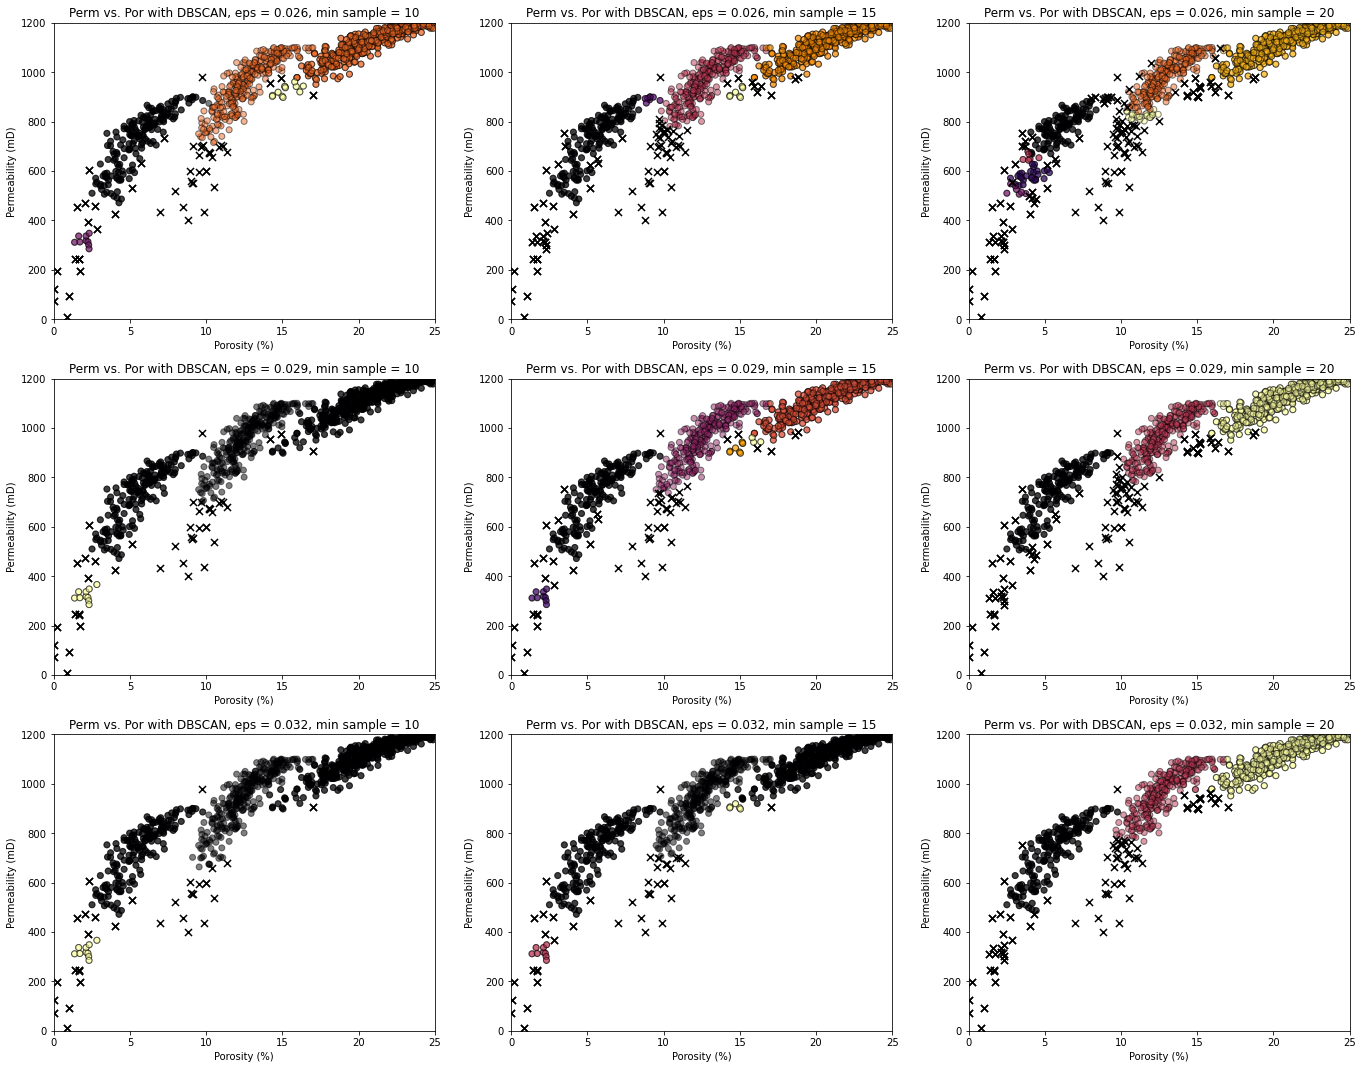

In [15]:
eps_mat = [0.026,0.029,0.032] 
min_sample_mat = [10, 15, 20]

index = 1
for eps in eps_mat:
    for min_sample in min_sample_mat:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample).fit(df[['n'+col[0],'n'+col[1]]].values)
        df['DBSCAN'] = dbscan.labels_ + 1
        
        plt.subplot(3,3,index)                          # plot the assigned training data and K prototypes
        df_in = df.loc[(df['DBSCAN'] != 0)]
        plt.scatter(df_in[col[0]], df_in[col[1]], c=df_in['DBSCAN'], alpha=0.5, edgecolor='k', cmap = cmap)
        df_outlier = df.loc[(df['DBSCAN'] == 0)]
        plt.scatter(df_outlier[col[0]],df_outlier[col[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
        plt.title(col[1] + ' vs. ' + col[0] + ' with DBSCAN, eps = ' + str(eps) + ', min sample = ' + str(min_sample)); plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.xlim(xlim)
        plt.ylim(ylim)
        index = index + 1
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.50, wspace=0.2, hspace=0.2)

Now let's try to use a more repeatable method to calculate the DBSCAN hyperparameters.

* **min samples** - we will assume 15 

* **eps** - we will use the nearest neighbour function to estimate it given the minimum number of samples

Let's calculate the nearest neighbour to each sample data in normalized feature space with the command:

```python 
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df[['nPor','nPerm']].values)
distances, indices = nbrs.kneighbors(df[['nPor','nPerm']].values)
```

We have a $n \times k$ array with the distances and the sample data indices:

* for each $n$ sample we have a row of nearest neighbour distances up to k nearest neighbours (closest to furthest in the columns), note the first neighbour is sample itself; therefore the first column is 0.

* we will then sort the rows in ascending order and plot relative to the sample index, $i = 1,\ldots,n-1$

Then we will plot the distances vs. the sample index in the ascending order

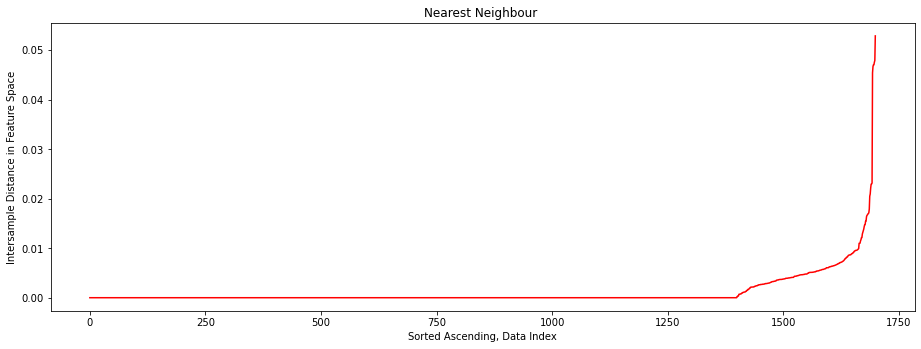

In [16]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df[['n' + col[0],'n' + col[1]]].values)
distances, indices = nbrs.kneighbors(df[['n' + col[0],'n' + col[1]]].values)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, c = 'red'); plt.xlabel('Sorted Ascending, Data Index'); plt.ylabel('Intersample Distance in Feature Space')
plt.title('Nearest Neighbour ')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.00, wspace=0.2, hspace=0.2)

Now we look for the nearest neighbour distance with the maximum positive curvature, known as the 'elbow' of the nearest neighbour plot 

* this provides an indication of the cluster sizes

* we would estimate eps as just above 0.01 in this case.   

Some observations from DBSCAN

* the results are quite sensitive to the selection of **eps** and **min_samples**.

* in the sparse part of the 'cluster' many of the data are assigned to other groups are remain as outliers

In this case, the result with this estimated eps hyperparameter is not satisfying. 

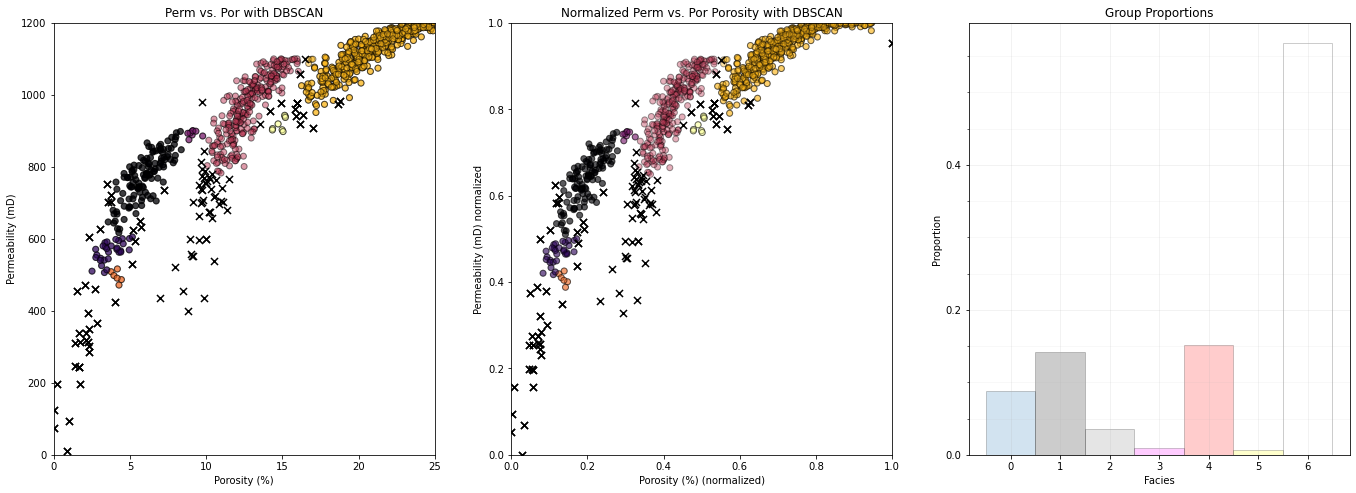

In [17]:
dbscan = DBSCAN(eps=0.025, min_samples=15).fit(df[['n' + col[0],'n' + col[1]]].values)
df['DBSCAN'] = dbscan.labels_ + 1

cmap = plt.cm.inferno

plt.subplot(131)                          # plot the assigned training data and K prototypes
df_in = df.loc[(df['DBSCAN'] != 0)]
plt.scatter(df_in[col[0]], df_in[col[1]], c=df_in['DBSCAN'], alpha=0.5, edgecolor='k', cmap = cmap)
df_outlier = df.loc[(df['DBSCAN'] == 0)]
plt.scatter(df_outlier[col[0]],df_outlier[col[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with DBSCAN'); plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(132)                          # plot the training data and K prototypes
plt.scatter(df_in['n' + col[0]], df_in['n' + col[1]], c=df_in['DBSCAN'], alpha = 0.4, linewidths=1.0, edgecolors="black", cmap = cmap)
plt.scatter(df_outlier['n' + col[0]],df_outlier['n' +col[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
# option to visualize the identified core samples
#plt.scatter(dbscan.components_[:,0],dbscan.components_[:,1],c='red',s=50,marker = 's',edgecolor='k',cmap = cmap,alpha = 0.2)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' Porosity with DBSCAN'); plt.xlabel(xlabel + ' (normalized)'); plt.ylabel(ylabel + ' normalized')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.subplot(133)
N, bins, patches  = plt.hist(df['DBSCAN'],alpha=0.2,edgecolor="black",bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5],range=[0.5,2.5],density = True)
patches[1].set_facecolor('black'); patches[3].set_facecolor('magenta'); patches[4].set_facecolor('red')
patches[5].set_facecolor('yellow'); patches[6].set_facecolor('white'); patches[2].set_facecolor('gray');
plt.title('Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(0.0, 6.1, 1))
ax.set_yticks(np.arange(0, 0.6, 0.2))
ax.set_yticks(np.arange(0, 0.6, 0.05), minor=True)

#plt.grid(which = 'both',color = 'black',alpha = 0.01)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)



####  Spectral Clustering

Spectral clustering is based on graph theory, where the sample data are mapped to a $n \times n$ array that describes the degree of pairwise 'connectivity' between the sample data, and then Eigen vectors are calculated to reduce the dimensionality and k-means clustering is applied on the retained Eigen vectors to find the clusters.

The advantages of the method includes:

* the ability to encode connectivity between the sample dataset. While kernel and nearest neightbour approaches are commone, this step could include integration of various information sources.  

* the Eigen values provide useful diagnostic information to inform the number of natural clusters based on the degree of cutting of connection required to separate the dataset

* the Eigen vectors provide reduced dimensional representations of the high dimensional representation of pairwise connection

**Other Resources** - I found the short article with demonstration on [Spectral Clustering](https://towardsdatascience.com/spectral-clustering-aba2640c0d5b) by William Fleshman quite useful to understand this approach. 

These are the steps for spectral clustering:

* **Calculate the Simularity Graph and Matrix**

* **Calculate the Degree Matrix**

* **Calculate the Graph Laplacian Matrix**

* **Perform Dimensionality Reduction on the Graph Laplacian Matrix**

* **Assign Clusters in the Reduced Dimensionality**

##### Calculate the Simularity Graph and Matrix

Spectral clustering first calculates a graph of the data in predictor space

* a graph is comprised of the samples (nodes) and connections (edges) between the samples

There are mulitple methods to represent the sample data graph in predictor feature space:

* **affinity matrix** the connections are represented as an $n \times n$ matrix with 0 if no connection and a measure of similarity for connected samples. This is accomplished with radial basis function kernel with a specified gamma, or other kernels such as polynomial.

* **adjacency matrix** the connections are represented as a $n \times n$ matrix with 0 if no connection and 1 if connected.  This matrix may be calculated with k-nearest neighbor (up to a determined maximum number of neighbors), epsilon-neighborhood (all points withing a radius) or radial basis function kernel with a specified gamma, or other kernels such as polynomial. 

##### Calculate the Degree Matrix

The degree matrix is a diagonal matrix where elements $i,i$ are the summation of the adjacency matrix row $i$.

##### Calculate the Graph Laplacian Matrix 

The graph Laplacian is the adjacency matrix subtracted from the degree matrix.

##### Perform Dimensionality Reduction on the Graph Laplacian Matrix

Calculate the Eigen Values and Eigen Vectors of the Graph LaplacianThe result is $n$ Eigen vectors (of length $n$) and $n$ Eigen values.  We can interprete the Eigen values / vectors as follows:

* the number of zero Eigen values are the number of connected parts of the dataset.  For example, when the simularity graph indicates 0 similarity for all sample data to sample data combinations, all Eigen values are 0, all sample data are independent connected parts. If all data are connected, then all Eigen values except for the first are nonzero, indicating all sample data in one connected part.

* the first nonzero Eigen value is the **spectral gap**. It provides an indication of the density of the sample to sample connections. For example, if the affinity is 1.0 for all sample data pairs, the spectral gap is equal to $n$.

* the second Eigen value is the **Fiedler value** and the associated Eigen vector is the **Fiedler vector**. It indicates the level of graph cut to separate the sample dataset into 2 parts. For example, if the second Eigen value is 0 already, then the dataset is already separated into atleast 2 parts; therefore, no cuts are needed!

##### Assign Clusters in the Reduced Dimensionality

The final step is to assign the clusters based on the result from the dimensionality reduced graph Laplacian matrix.  There are a couple of methods possible demonstrated here:

1. We can use the Eigen values to determine the number of clusters:

* jumps in Eigen values are used to identify the natural number of clusters in the dataset. i.e. if we add another connected group we would have to do a lot more cuts!

2. Assignment of clusters by Eigen vector values:

* the sign of the Fiedler vector provides the 2 custers (positive and negative) if the dataset where cut into 2 groups.

3. Assignment of clusters by k-means clustering applied to the Eigen vectors 

* we apply k-means clustering on the Eigen vectors up to the determined number of clusters. This finds the groups asessed while integrating pairwise connections of the sample data.

After some iteration I found this impementation satisfactory:

* 5 clusters

* affinity calculated with the rabial basis kernal applied to the sample data with a $\gamma = 1000$

* k-mean clustering applied to the $2^{nd}$ through $5^{th}$ 

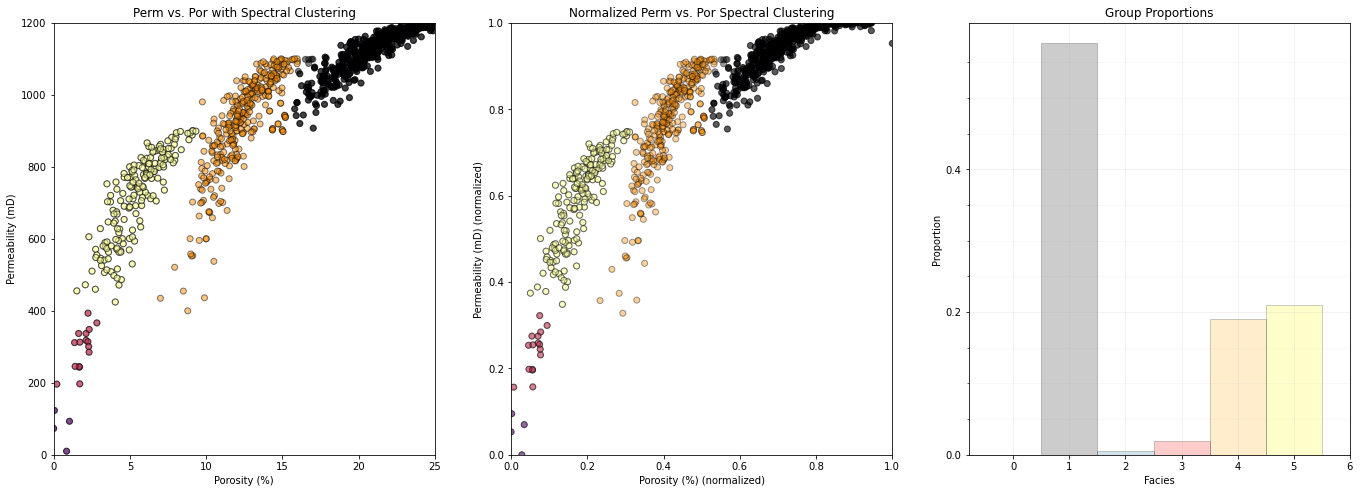

In [18]:
spectral = SpectralClustering(n_clusters=5,assign_labels="kmeans",affinity = 'rbf',
                              gamma = 1000,n_neighbors = 200,random_state=230).fit(df[['n' + col[0],'n' + col[1]]].values)
df['SPECTRAL'] = spectral.labels_ + 1

cmap = plt.cm.inferno

plt.subplot(131)                          # plot the assigned training data and K prototypes

plt.scatter(df[col[0]], df[col[1]], c=df['SPECTRAL'], alpha=0.5, edgecolor='k', cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with Spectral Clustering'); plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(132)                          # plot the training data and K prototypes
plt.scatter(df['n' + col[0]], df['n' + col[1]], c=df['SPECTRAL'], alpha = 0.4, linewidths=1.0, edgecolors="black", cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' Spectral Clustering'); plt.xlabel(xlabel + ' (normalized)'); plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.subplot(133)
N, bins, patches  = plt.hist(df['SPECTRAL'],alpha=0.2,edgecolor="black",bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5],range=[0.5,4.5],density = True)
patches[1].set_facecolor('black'); patches[3].set_facecolor('red'); patches[4].set_facecolor('orange'); patches[5].set_facecolor('yellow') 
plt.title('Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(0.0, 6.1, 1))
ax.set_yticks(np.arange(0, 0.6, 0.2))
ax.set_yticks(np.arange(0, 0.6, 0.05), minor=True)

#plt.grid(which = 'both',color = 'black',alpha = 0.01)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)

Let's look at the affinity matrix that was calculated to drive this result.

* this is the pairwise connection between all of the sample data

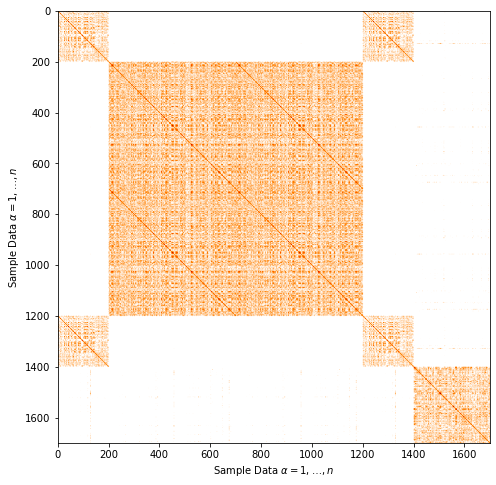

In [19]:
plt.subplot(111)                                          # plot the affinity matrix 
plt.imshow(spectral.affinity_matrix_,cmap = plt.cm.gist_heat_r,vmin = 0.0, vmax = 1.0)
plt.xlabel(r'Sample Data $\alpha = 1, \ldots ,n$'); plt.ylabel(r'Sample Data $\alpha = 1, \ldots ,n$')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)

Here's some general observations:

* there is a large number of pairwise connections betwee the sample data

* the data is ordered with a group from sample 0 to approximately sample 200, sample approximately 200 to sample approximately 1200 etc.  

* the groups over 0-200 and 1200-1400 approximately appear to be close to each other

Once again let's demonstrate the sensitivity of the solution to the model hyperparameters.

Let's explore the sensivity in the parameters, by looking at the results over a $3 \times 3$ combinatorial of hyperparameters. Run this the first time as is and then try making changes the the values in this code.

```python
ncluster_mat = [2,5,8] 
gamma_mat = [500,1000,2000]
```

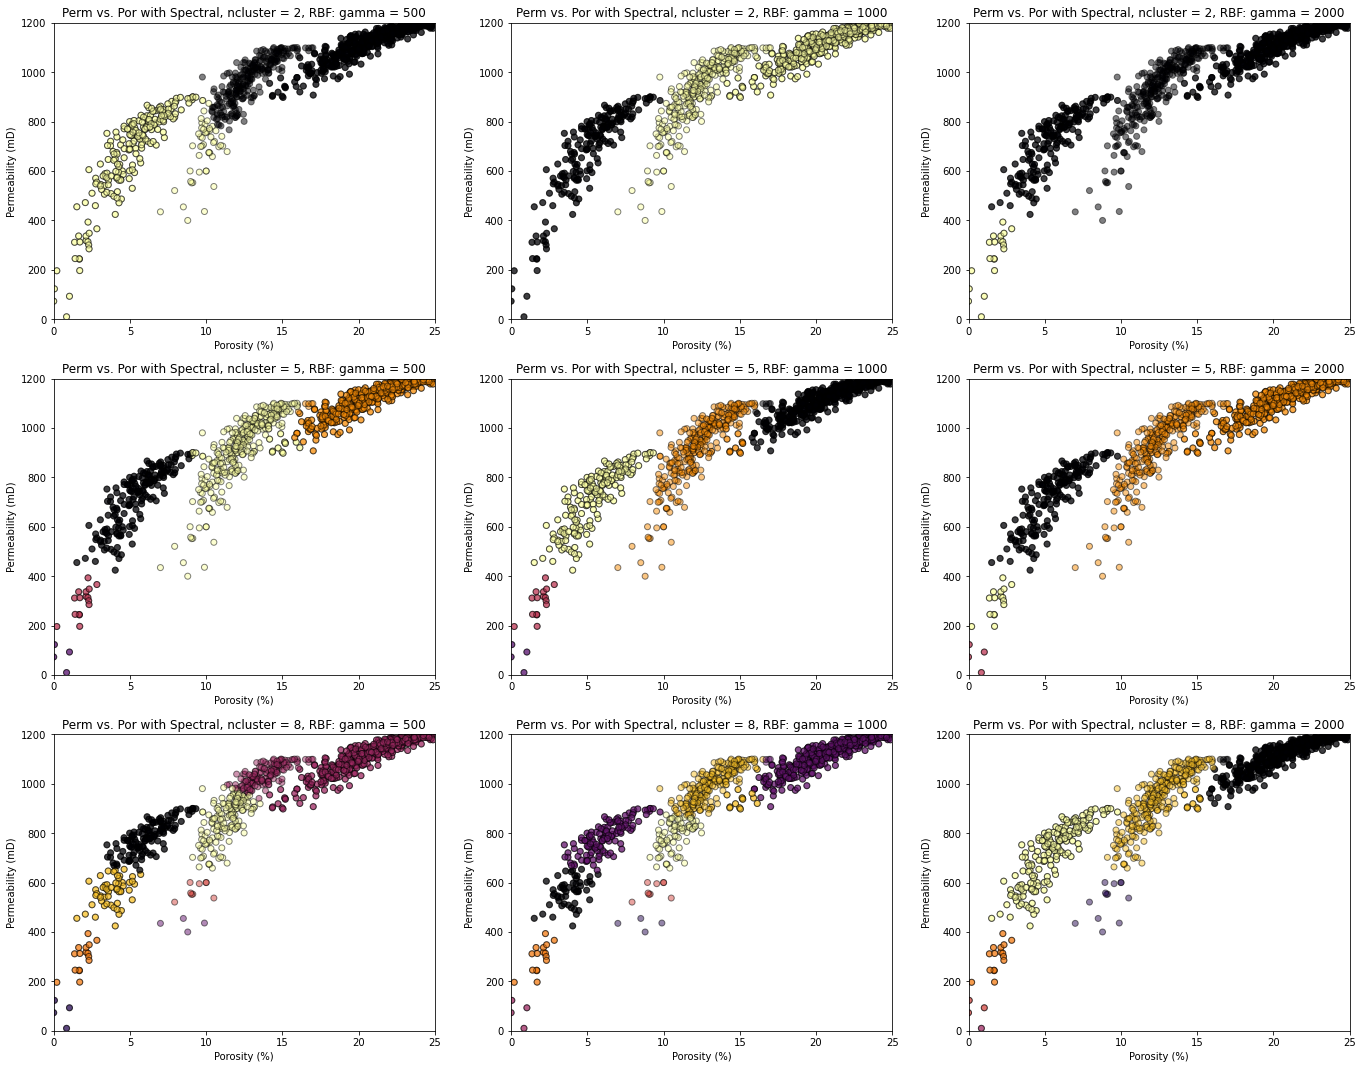

In [20]:
ncluster_mat = [2,5,8] 
gamma_mat = [500,1000,2000]

index = 1
for ncluster in ncluster_mat:
    for gamma in gamma_mat:
        spectral = SpectralClustering(n_clusters=ncluster,assign_labels="kmeans",affinity = 'rbf',
                              gamma = gamma,n_neighbors = 200,random_state=230).fit(df[['n' + col[0],'n' + col[1]]].values)
        df['SPECTRAL'] = spectral.labels_ + 1
        
        plt.subplot(3,3,index)                          # plot the assigned training data and K prototypes
        plt.scatter(df[col[0]], df[col[1]], c=df['SPECTRAL'], alpha=0.5, edgecolor='k', cmap = cmap)
        plt.title(col[1] + ' vs. ' + col[0] + ' with Spectral, ncluster = ' + str(ncluster) + ', RBF: gamma = ' + str(gamma)); plt.xlabel('Porosity (%)'); plt.ylabel('Permeability (mD)')
        plt.xlim(xlim)
        plt.ylim(ylim)
        index = index + 1
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.50, wspace=0.2, hspace=0.2)

Some observations from these spectral cluster assignments:

* as expected the method is able to devide the sample data into a specified number of clusters

* as gamma increases, the pairwise affinity increases between the sample data, resulting in joining groups that now appear more connected

#### Comments

Try other clustering methods, there are many more, well matched for various sample data structures.

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>